In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, models

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from PIL import Image
from pathlib import Path

import os 

In [2]:
# Set Device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

directory_path = Path('/kaggle/input/mura-v11/')
os.chdir(str(Path(directory_path)))

cuda


In [3]:
# Set Path
data_path = Path('MURA-v1.1')

train_df = pd.read_csv(data_path/'train_image_paths.csv', names=['image_path'])
valid_df = pd.read_csv(data_path/'valid_image_paths.csv', names=['image_path'])
trainlabel_df = pd.read_csv(data_path/'train_labeled_studies.csv', names=['image_path', 'label'])
validlabel_df = pd.read_csv(data_path/'valid_labeled_studies.csv', names=['image_path', 'label'])


In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx, 0]
        image = Image.open(image_path).convert('LA')
        label = 1 if 'positive' in image_path else 0

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456], std=[0.224]),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.456], std=[0.224]),
])
study_types = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
study_train_df, study_valid_df, train_dataset, valid_dataset, train_dataloader, valid_dataloader = {}, {}, {}, {}, {}, {}


for study_type in study_types:
    study_train_df[study_type] = train_df[train_df['image_path'].str.contains(study_type)]
    study_valid_df[study_type] = valid_df[valid_df['image_path'].str.contains(study_type)]
    
    train_dataset[study_type] = Dataset(study_train_df[study_type], transform=train_transform)
    valid_dataset[study_type] = Dataset(study_valid_df[study_type], transform=valid_transform)
    
    train_dataloader[study_type] = DataLoader(train_dataset[study_type], batch_size=16, shuffle=True)
    valid_dataloader[study_type] = DataLoader(valid_dataset[study_type], batch_size=16, shuffle=False)

In [6]:
for study_type in study_types:
    print(study_type, len(train_dataset[study_type]), len(valid_dataset[study_type]))

XR_ELBOW 4931 465
XR_FINGER 5106 461
XR_FOREARM 1825 301
XR_HAND 5543 460
XR_HUMERUS 1272 288
XR_SHOULDER 8379 563
XR_WRIST 9752 659


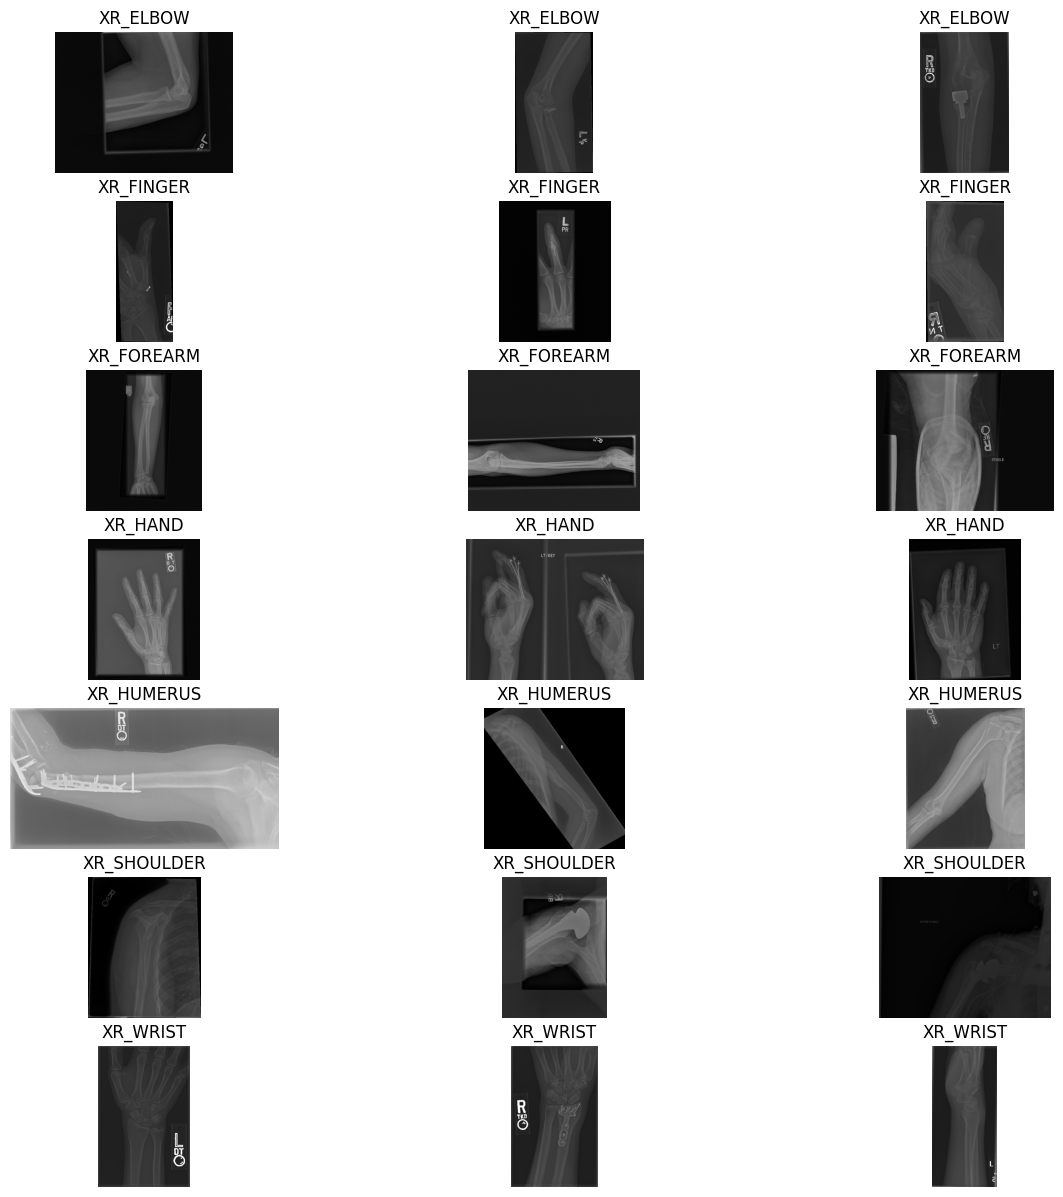

In [8]:
fig, axs = plt.subplots(7, 3, figsize=(15, 15))
for study_type in study_types:
    indices = random.sample(range(len(train_dataset[study_type])), 3)
    for i, idx in enumerate(indices):
        image_path = study_train_df[study_type].iloc[idx]['image_path']
        image = Image.open(image_path).convert('LA')
        rows = study_types.index(study_type)
        cols = i
        axs[rows, cols].imshow(image)
        axs[rows, cols].axis('off')
        axs[rows, cols].set_title(study_type)

plt.show()

In [15]:
# U-NET Architecture
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.sequential(x)

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
        
    def forward(self, inputs, skip):
        x = self.up(inputs)
        concat = torch.cat([x, skip], axis=1)
        x = self.conv(concat)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = encoder_block(2, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)

        self.mid = conv_block(512, 1024)

        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)

        self.last = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    
    def forward(self, inputs):
        enc1, p1 = self.enc1(inputs)
        enc2, p2 = self.enc2(p1)
        enc3, p3 = self.enc3(p2)
        enc4, p4 = self.enc4(p3)

        mid = self.mid(p4)

        dec1 = self.dec1(mid, enc4)
        dec2 = self.dec2(dec1, enc3)
        dec3 = self.dec3(dec2, enc2)
        dec4 = self.dec4(dec3, enc1)

        outputs = torch.sigmoid(self.last(dec4))

        return outputs

In [16]:
model = build_unet()
model.to(device)

from torchinfo import summary
summary(model, input_size=(16, 2, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
build_unet                               [16, 1, 224, 224]         --
├─encoder_block: 1-1                     [16, 64, 224, 224]        --
│    └─conv_block: 2-1                   [16, 64, 224, 224]        --
│    │    └─Sequential: 3-1              [16, 64, 224, 224]        38,400
│    └─MaxPool2d: 2-2                    [16, 64, 112, 112]        --
├─encoder_block: 1-2                     [16, 128, 112, 112]       --
│    └─conv_block: 2-3                   [16, 128, 112, 112]       --
│    │    └─Sequential: 3-2              [16, 128, 112, 112]       221,952
│    └─MaxPool2d: 2-4                    [16, 128, 56, 56]         --
├─encoder_block: 1-3                     [16, 256, 56, 56]         --
│    └─conv_block: 2-5                   [16, 256, 56, 56]         --
│    │    └─Sequential: 3-3              [16, 256, 56, 56]         886,272
│    └─MaxPool2d: 2-6                    [16, 256, 28, 28]         --
├

In [17]:
def train(model, train_dataloader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = output[:, 0, 0, 0]
        target = target.float()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step() 
    return loss.item()

In [18]:
def validate(model, val_dataloader, criterion):
    model.eval()
    val_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output[:, 0, 0, 0]
            target = target.float()
            loss = criterion(output, target)
            val_loss += loss.item()
            predicted = (output >= 0.5).float()  
            total += target.size(0)
            correct += (predicted == target).sum().item()
    val_loss /= len(val_dataloader)
    accuracy = (correct / total) * 100
    return val_loss, accuracy


Epoch 1/10, Training Loss: 8.4887, Validation Loss: 19.5935, Validation Accuracy: 59.3323
Epoch 2/10, Training Loss: 5.9682, Validation Loss: 19.6284, Validation Accuracy: 57.0561
Epoch 3/10, Training Loss: 4.2577, Validation Loss: 19.6127, Validation Accuracy: 61.3050
Epoch 4/10, Training Loss: 9.7722, Validation Loss: 19.6810, Validation Accuracy: 60.5463
Epoch 5/10, Training Loss: 12.0481, Validation Loss: 19.4940, Validation Accuracy: 61.3050
Epoch 6/10, Training Loss: 5.3997, Validation Loss: 19.7373, Validation Accuracy: 61.7602
Epoch 7/10, Training Loss: 2.6373, Validation Loss: 19.6300, Validation Accuracy: 64.6434
Epoch 8/10, Training Loss: 7.8480, Validation Loss: 19.6496, Validation Accuracy: 64.4917
Epoch 9/10, Training Loss: 10.4389, Validation Loss: 19.7606, Validation Accuracy: 63.7329
Epoch 10/10, Training Loss: 10.7122, Validation Loss: 19.7240, Validation Accuracy: 62.9742


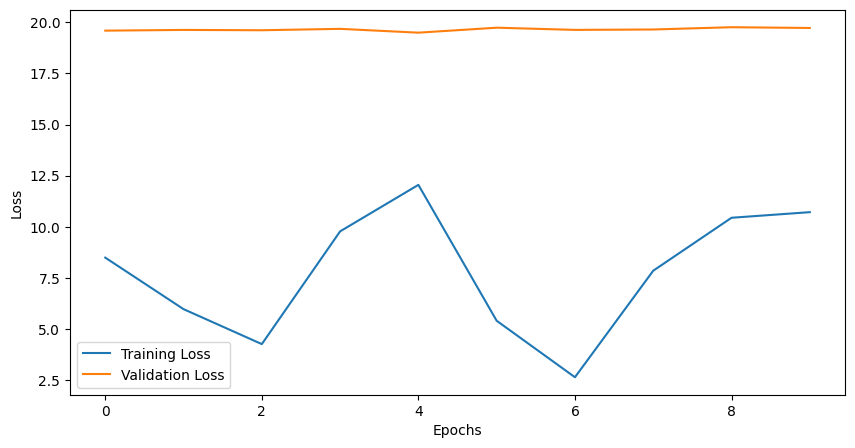

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10

study_types = ['XR_WRIST', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_FOOT', 'XR_ELBOW']
study_type = study_types[0]

train_losses = []
validation_losses = []
accuracy1 = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader[study_type], criterion, optimizer)
    validation_loss, accuracy = validate(model, valid_dataloader[study_type], criterion)
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {validation_loss:.4f}, '
          f'Validation Accuracy: {accuracy:.4f}')
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    accuracy1.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

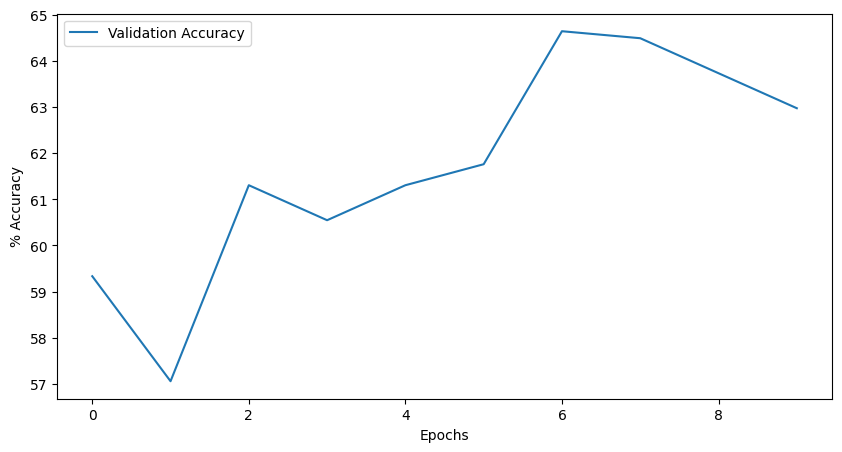

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(accuracy1, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()